# 第二次课堂实验
scikit-image 是专注于图像处理的 Python 包，并且使用原生的 NumPy 数组作为图像对象。本次实验中，你将使用 skimage 库使用霍夫变换来检测图片中的几何形状，包括直线、圆和椭圆；另外，你也需要动手实现均值迭代阈值法和 OTSU 法两个基本的图像分割算法。

scikit-image 已经包含在 Anaconda 环境内，文档地址：http://scikit-image.org/docs/dev/user_guide.html

## 实验 1 - 霍夫线变换
霍夫变换 wiki: https://zh.wikipedia.org/wiki/%E9%9C%8D%E5%A4%AB%E5%8F%98%E6%8D%A2
### 生成测试图片

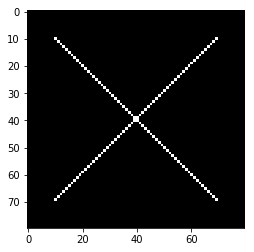

In [3]:
import skimage.transform as st
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 生成测试图片
image = np.zeros((80, 80))
idx = np.arange(10, 70)
image[idx[::-1], idx] = 255 # 绘制 "\"
image[idx, idx] = 255       # 绘制 "/"

plt.imshow(image, plt.cm.gray)

### 显示 hough 变换所得数据
这里你需要使用函数 skimage.transform.hough_line(img) ，[查看文档说明](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_line)。

- hough_line 返回值: (h, theta, distance)
    - h: 霍夫变换累积器 
    - theta: 点与x轴的夹角集合，一般为0-179度
    - distance: 点到原点的距离
- Tips: 
    - 可直接使用 plt.show(np.log(1+h)) 可视化霍夫变换得到的数据，这里你也需要考虑为何不直接 plt.show(h)

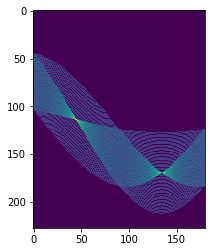

In [12]:
# TODO:
# 你的代码
h,theta,d = st.hough_line(image)
plt.imshow(np.log(1+h))
#print theta


### 显示检测出的线条
具体的代码已经给出，你可以结合 [霍夫变换 wiki](https://zh.wikipedia.org/wiki/%E9%9C%8D%E5%A4%AB%E5%8F%98%E6%8D%A2) 理解他们。

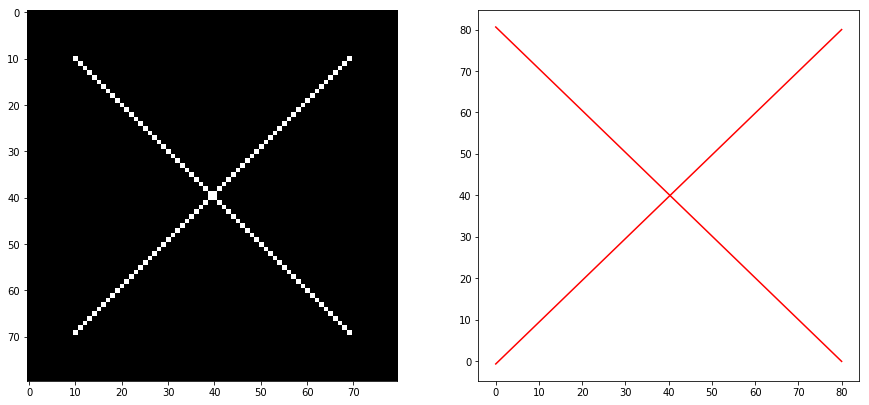

In [13]:
fig = plt.figure(figsize=(15, 15))
ax0 = fig.add_subplot(221)
ax0.imshow(image, plt.cm.gray)

ax1 = fig.add_subplot(222)
row, col = image.shape

# 这里的 h, theta, d 是上一部分 hough_line 的返回值
for _, angle, dist in zip(*st.hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - col * np.cos(angle)) / np.sin(angle)
    ax1.plot((0, col), (y0, y1), '-r')

## 实验 2 - 霍夫圆和椭圆变换
与霍夫线变换类似，如果给定圆心和半径，检测其它点是否在圆上即可。在图像中，我们将每个非0像素点作为圆心点，以一定的半径进行检测，如果有一个点在圆上，我们就对这个圆心累加一次。如果检测到一个圆，那么这个圆心点就累加到最大，成为峰值。因此，在检测结果中，一个峰值点，就对应一个圆心点。

- 霍夫圆检测的函数：
    - skimage.transform.hough_circle(image, radius) [Doc](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_circle)
        - radius是一个数组，表示半径的集合，如[3，4，5，6]
        - 返回一个3维的数组（radius index, M, N), 第一维表示半径的索引，后面两维表示图像的尺寸

### 绘制两个圆形

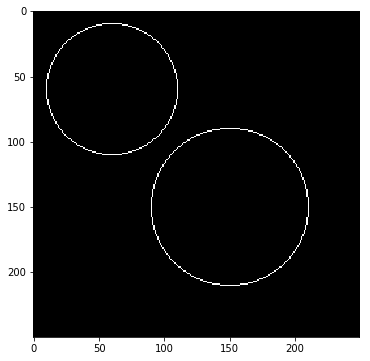

In [14]:
from skimage import draw
img = np.zeros((250, 250))
rr0, cc0 = draw.circle_perimeter(60, 60, 50)
rr1, cc1 = draw.circle_perimeter(150, 150, 60)
img[cc0, rr0] = 255
img[rr1, cc1] = 255

# 显示原图
plt.figure(figsize=(6, 6))
plt.imshow(img, plt.cm.gray)

### 使用霍夫圆变换将他们检测出来

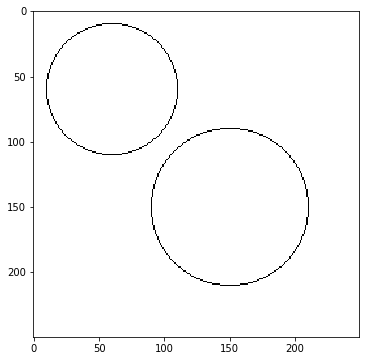

In [15]:
from skimage import feature
hough_radii = np.arange(50, 80, 5)  #半径范围
hough_res = st.hough_circle(img[:,:], hough_radii)  #圆变换 

centers = []  #保存所有圆心点坐标
accums = []   #累积值
radii = []    #半径

for radius, h in zip(hough_radii, hough_res):
    #每一个半径值，取出其中两个圆
    num_peaks = 2
    peaks =feature.peak_local_max(h, num_peaks=num_peaks) #取出峰值
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius] * num_peaks)

# 画出最接近的圆
image = np.copy(img)
image.fill(255)
for idx in np.argsort(accums)[::-1][:2]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = draw.circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = 0

plt.figure(figsize=(6, 6))
plt.imshow(image, plt.cm.gray)

## 实验 3 - 在真实样本上测试
### 霍夫圆变换 - 检测出咖啡图片中的椭圆杯口
需要注意的是__霍夫椭圆变换速度非常慢，应避免图像太大。__

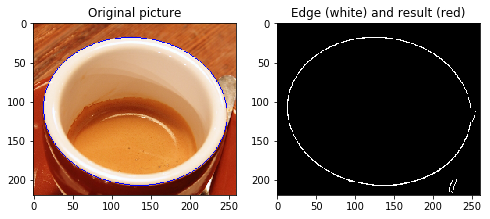

In [16]:
from skimage import color, data
#加载图片，转换成灰度图并检测边缘
image_rgb = data.coffee() 
image_rgb = image_rgb[0:220, 160:420] #裁剪原图像，不然速度非常慢
image_gray = color.rgb2gray(image_rgb)
edges = feature.canny(image_gray, sigma=2.0, low_threshold=0.55, high_threshold=0.8)

#执行椭圆变换
result = st.hough_ellipse(edges, accuracy=20, threshold=250,min_size=100, max_size=120)
result.sort(order='accumulator') #根据累加器排序

#估计椭圆参数
best = list(result[-1])  #排完序后取最后一个
yc, xc, a, b = [int(round(x)) for x in best[1:5]]
orientation = best[5]

#在原图上画出椭圆
cy, cx = draw.ellipse_perimeter(yc, xc, a, b, orientation)
image_rgb[cy, cx] = (0., 0., 255.) #在原图中用蓝色表示检测出的椭圆

#分别用白色表示canny边缘，用红色表示检测出的椭圆，进行对比
edges = color.gray2rgb(edges)
edges[cy, cx] = (250, 0, 0) 

# 创建显示窗口.
fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

# 显示原图像
ax1.set_title('Original picture')
ax1.imshow(image_rgb)

# 显示canny边缘
ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges[:,:,0], plt.cm.gray)

plt.show()

### 霍夫线变换
- 这里可以使用了另一个检测直线的霍夫变换函数 __skimage.transform.probabilistic_hough_line(img, threshold=10, line_length=5,line_gap=3)__
    - 参数：
        - img: 待检测的图像。
        - threshold： 阈值，可先项，默认为10
        - line_length: 检测的最短线条长度，默认为50
        - line_gap: 线条间的最大间隙。增大这个值可以合并破碎的线条。默认为10
    - 返回值：
        - lines: 线条列表, 格式如((x0, y0), (x1, y0))，标明开始点和结束点。

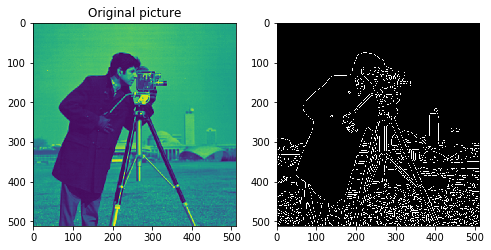

In [4]:
# 使用 Probabilistic Hough Transform.
from skimage import feature
from skimage import color, data
image2 = data.camera()  # 从 data 模块中读取示例图片
edges2 = feature.canny(image2, sigma=2, low_threshold=1, high_threshold=25)
lines2 = st.probabilistic_hough_line(edges2, threshold=10, line_length=5,line_gap=3)
# 创建显示窗口.
# 你的代码...
fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))

# 显示原图像
# 你的代码...
ax1.set_title('Original picture')
ax1.imshow(image2)

# 显示canny边缘
# 你的代码...
edges2 = color.gray2rgb(edges2)
ax2.imshow(edges2[:,:,0], plt.cm.gray)
plt.show()




In [5]:
# 用plot绘制出所有的直线
ax2.imshow(edges2 * 0)
for line in lines2:
    p0, p1 = line
    ax2.plot((p0[0], p1[0]), (p0[1], p1[1]))
row2, col2 = image2.shape
ax2.axis((0, col2, row2, 0))
ax2.set_title('Probabilistic Hough')
ax2.set_axis_off()
plt.show()

## 实验四 - 均值迭代阈值分割法
- 这里需要你动手实现该算法，最终效果已经给出
    - Step1. 选择一个初始的估计阈值T（可以用图像的平均灰度值作为初始阈值）
    - Step2. 用该阈值把图像分割成两个部分R1和R2
    - Step3. 分别计算R1和R2的灰度均值μ1和μ2
    - Step4. 选择一个新的阈值T＝(μ1＋μ2)/2
    - Step5. 重复2-4直至后续迭代中平均灰度值μ1和μ2保持不变
- 完成这部分代码后，你也可以尝试 skimage.filters 库中的其他函数达到近似的效果，比如 threshold_otsu, threshold_li 等

In [21]:
from skimage import io
image3 = io.imread('Lenna.jpg')
image3_gray = color.rgb2gray(image3)
# TODO: 这里是你的代码
ith = image3_gray.shape[0]
jth = image3_gray.shape[1]
R1 = 0
R2 = 0
T = np.mean(image3_gray)
for i in range(2):
    for i in range(ith):
        for j in range(jth):
            if image3_gray[i,j]>T:
                R1 = R1 + image3_gray[i,j] 
            else :
                R2 = R2 +image3_gray[i,j]
    u1 = R1/(ith*jth)
    u2 = R2/(ith*jth)
    T = (u1+u2)/2
    print T

0.228936681432
0.457873362864


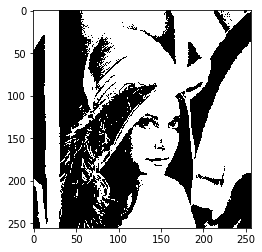

In [27]:
from skimage import filters
T = filters.threshold_isodata(image3_gray)
mask = image3_gray > T
plt.imshow(mask, plt.cm.gray)

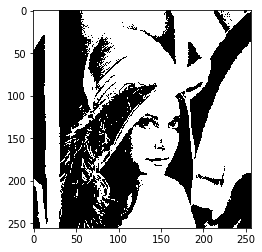

In [22]:
# 最终效果
from skimage import filters
val = filters.threshold_isodata(image3_gray)
mask = image3_gray > val
plt.imshow(mask, plt.cm.gray)